# Phase 1 - Factors Analysis

In [275]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

### Load data

In [276]:
depression_df = pd.read_csv("data.tsv", sep="\t", header=0)

### Choose Relevant Columns
The columns were grouped into five categories to get a better understanding of the data. The categories are:
- Categorical binary
- Categorical nominal
- Categorical ordinal
- Numerical discrete
- Numerical continuous

In [277]:
def adyo(cols):
    return np.array([[f"{p}{b}" for b in cols] for p in ["AD", "YO"]]).ravel().tolist()

In [278]:
indicator_col = "DEPRESSIONINDEX"
age_col = ["CATAG2", "CATAG3", "CATAG7"][0]

cols_dict = {
    "cat_bin": adyo(
        [
            "_MDEA1",
            "_MDEA2",
            "_MDEA3",
            "_MDEA4",
            "_MDEA5",
            "_MDEA6",
            "_MDEA7",
            "_MDEA9",
            "WRDBTR",
            "WRTHOT",
            "WRNOGD",
            "WRDCSN",
            "WRCONC",
            "WRENRG",
            "WRWRTH",
            "WRPROB",
            "WRDLOT",
            "WRSTHK",
            "WRSLEP",
            "WRELES",
            "WRSATP",
            "WRSPLN",
            "WRJINO",
            "WRJITT",
            "WRSLNO",
            "WRSMOR",
            "WRLSL2",
            "WRDIET",
            "WRLOSE",
            "WRGNL2",
            "WRPREG",
            "WRGROW",
            "WRGAIN",
            "WREMOR",
            "WRPLSR",
            "WRLSIN",
            "WRDISC",
            "WRDEPR",
        ]
    )
    + [
        "MJANDCOKE",
        "ILLICITDRUGUSE",
        "LSYRILLICIT",
        "COKECRACK",
        "OTHERILLICIT",
        "MJCOKELY",
        "COCCRKLY",
        "MJGT12MO",
        "COCGT12MO",
        "ANYGT12MO",
        "IRPRVHLT",
        "WORKFORCE",
        "CRIMEHIST",
        "ANYSDRUG",
        "ANYATTACK",
        "ANYTHEFT",
        "TXLCAD",
        "RKIDSHH",
        "MARRIED",
        "CHILDRENINHOME",
        "IRSEX",
    ],
    "cat_nom": ["NEWRACE2", "ALCFMFPB", "EMPSTAT4", "CACHAR", "CATYPE", "IRMARIT"],
    "cat_ord": adyo(
        [
            "WRHRS",
            "WRDST",
            "WRCHR",
            "WRIMP",
        ]
    )
    + [
        "ANYINDEX",
        "IREDUC2",
        "INCOME",
        "INCOME_R",
        "POVERTY",
        "REVERSEPOP",
        "MOVESPY2",
        "NUMARREST",
        "HEALTH2",
        "NOMARR2",
        "DSTNCALM",
        "DSTTIRE",
        "DSTSITST",
        "DSTDEPRS",
        "DSTCHEER",
        "DSTNRVOS",
        age_col,
        indicator_col,
    ],
    "num_dis": adyo(
        [
            "WRAGE",
        ]
    )
    + ["SCHDSICK"],
    "num_con": [],
}

In [279]:
depression_df = depression_df[[col for cols in cols_dict.values() for col in cols]]

### Swap Non-Available Custom Values to nan

In [280]:
def swap_to_nan(df, cols, range):
    df = df.copy()
    lr, ur = range
    df[cols] = df[cols].where((df[cols] >= lr) & (df[cols] <= ur), np.nan)
    return df


depression_df = depression_df[depression_df[indicator_col] != -9]
depression_df.reset_index(drop=True, inplace=True)

range_dict = {
    "cat_bin": (0, 2),
    "cat_ord": (0, 20),
    "cat_nom": (0, 93),
    "num_dis": (0, 30),
    "num_con": (0, 0),
}

for col_type, cols in cols_dict.items():
    depression_df = swap_to_nan(depression_df, cols, range_dict[col_type])

### Merge AD and YO Columns
These columns are mutually exclusive and represent the same concept, so they can be combined into a single column.

In [281]:
for yo_col in depression_df.columns:
    if "YO" in yo_col:
        postfix = yo_col.split("YO")[1]
        ad_col = f"AD{postfix}"
        new_col = f"MERGED{postfix}"
        if ad_col in depression_df.columns:
            depression_df[yo_col].fillna(depression_df[ad_col], inplace=True)
            depression_df.rename(columns={yo_col: new_col}, inplace=True)
            depression_df.drop(columns=[ad_col], inplace=True)

            for col_type, cols in cols_dict.items():
                if yo_col in cols:
                    cols[cols.index(yo_col)] = new_col
                    cols.remove(ad_col)

### Add SOMATICDEP column and append it to cols_dict

In [282]:
symptoms_cols = [
    "MERGED_MDEA3",  # apetite
    "MERGED_MDEA4",  # sleep
    "MERGED_MDEA6",  # fatigue
    indicator_col,
]
if all(symptom in depression_df.columns for symptom in symptoms_cols):
    som_dep_df = depression_df[symptoms_cols].copy()
    som_dep_df["DEPRESSION"] = np.where(som_dep_df[indicator_col] > 0, 1, 2)
    som_dep_df.drop(columns=indicator_col, inplace=True)

    som_dep_no = som_dep_df.eq(2).any(axis=1)
    som_dep_yes = som_dep_df.eq(1).all(axis=1)

    depression_df["SOMATICDEP"] = np.nan
    depression_df.loc[som_dep_no, "SOMATICDEP"] = 0
    depression_df.loc[som_dep_yes, "SOMATICDEP"] = 1

    cols_dict["cat_bin"].append("SOMATICDEP")
else:
    print("Not all symptom columns are present")

### Drop columns that are all nan and filter out these names from the column lists

In [283]:
original_cols = depression_df.columns.tolist()
depression_df.dropna(axis=1, how="all", inplace=True)
remaining_cols = depression_df.columns.tolist()
dropped_cols = list(set(original_cols) - set(remaining_cols))

for key, value in cols_dict.items():
    cols_dict[key] = list(set(value) & set(remaining_cols))
    
print(f"Dropped empty columns: {dropped_cols}")

Dropped empty columns: ['DSTTIRE', 'DSTSITST', 'DSTDEPRS', 'DSTNCALM']


### Drop columns that were probably used to create DEPRESSIONINDEX
Columns that start with 'AD', 'YO' and 'DST' are dropped because they were probably used to create DEPRESSIONINDEX. This prevents data leakage.

In [284]:
filter_out = ["MERGED", "DST"]

depression_df.drop(columns=[col for col in depression_df.columns if any(f in col for f in filter_out)], inplace=True)

for key, value in cols_dict.items():
    cols_dict[key] = [col for col in value if not any(f in col for f in filter_out)]

### Drop col if more than PERCENTAGE_THRESHOLD of the values are nan

<Axes: xlabel='Columns', ylabel='Percentage of missing values'>

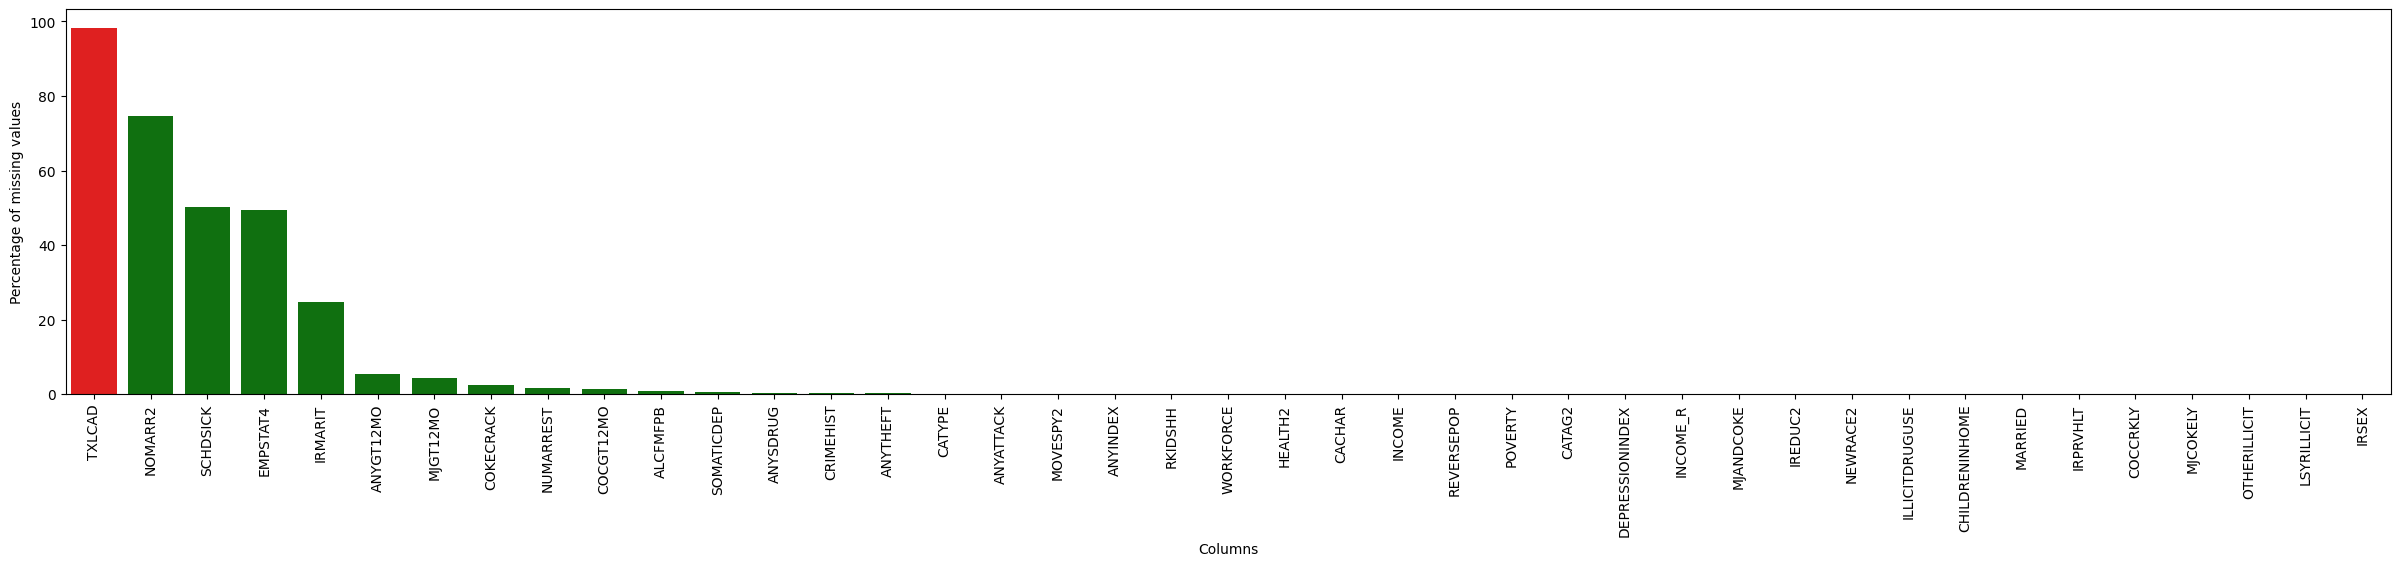

In [285]:
PERCENTAGE_THRESHOLD = 80
stats = (
    depression_df.isnull().sum().sort_values(ascending=False)
    / depression_df.shape[0]
    * 100
)
depression_df = depression_df[stats[stats < PERCENTAGE_THRESHOLD].index]
for key, value in cols_dict.items():
    cols_dict[key] = [col for col in value if col in depression_df.columns]

colors = ["green" if value < PERCENTAGE_THRESHOLD else "red" for value in stats]
plt.figure(figsize=(30, 5))
plt.xlabel("Columns")
plt.ylabel("Percentage of missing values")
plt.xticks(rotation=90)
sns.barplot(y=stats, x=stats.index, palette=colors, hue=stats.index)

### Preliminary Analysis

In [286]:
def get_pearson(df):
    return df.corr("pearson")


def get_spearman(df):
    return df.corr("spearman")


def get_chi2(df, col):
    results = []
    for var_col in set(df.columns.tolist()) - set([col]):
        contingency_table = pd.crosstab(df[col], df[var_col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        results.append(
            {
                "Variable": var_col,
                "Chi2": chi2,
                "P": p,
                "Dof": dof,
                "Expected": expected,
                "Chi2/DoF": chi2 / dof,
            }
        )
    results_df = pd.DataFrame(results)
    return results_df


def analyse(
    df,
    cols_dict,
    indicator_col,
):
    numerical_cols = cols_dict["num_dis"] + cols_dict["num_con"]

    pearson_df = get_pearson(df[cols_dict["cat_ord"] + numerical_cols])
    spearman_df = get_spearman(df[cols_dict["cat_ord"] + numerical_cols])
    chi2_df = get_chi2(
        df[cols_dict["cat_bin"] + cols_dict["cat_nom"] + cols_dict["cat_ord"]],
        indicator_col,
    )

    return pearson_df, spearman_df, chi2_df

In [287]:
pearson_df, spearman_df, chi2_df = analyse(
    df=depression_df,
    cols_dict=cols_dict,
    indicator_col=indicator_col,
)

### Pearson and Spearman Correlation Analysis
The correlation analysis indicates that the factors are not strongly correlated with the DEPRESSIONINDEX. This suggests that the examined factors do not have a linear relationship with the level of depression.

<Axes: title={'center': 'Pearson correlation'}>

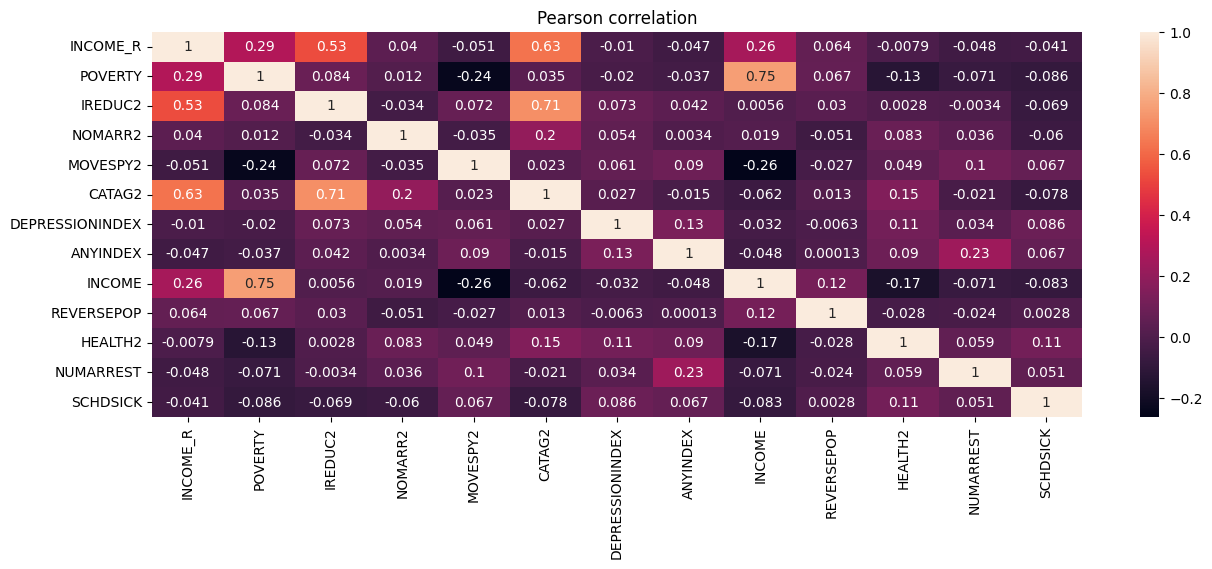

In [288]:
plt.figure(figsize=(15, 5))
plt.title("Pearson correlation")
sns.heatmap(pearson_df, annot=True)

<Axes: title={'center': 'Spearman correlation'}>

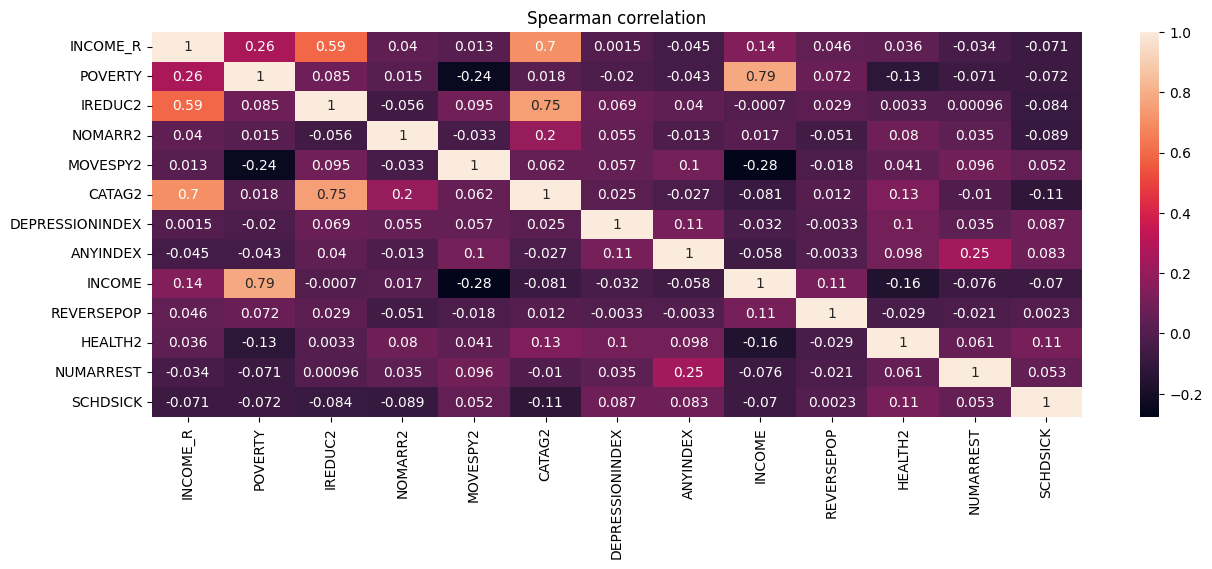

In [289]:
plt.figure(figsize=(15, 5))
plt.title("Spearman correlation")
sns.heatmap(spearman_df, annot=True)

### Chi-Square Test
Find N significantly different factors influencing the depression level. To take DoF into account, we will use the Chi2 divided by DoF. This makes it easier to compare the results.

<Axes: title={'center': 'Chi-Square test'}, xlabel='Variable', ylabel='Chi2/DoF'>

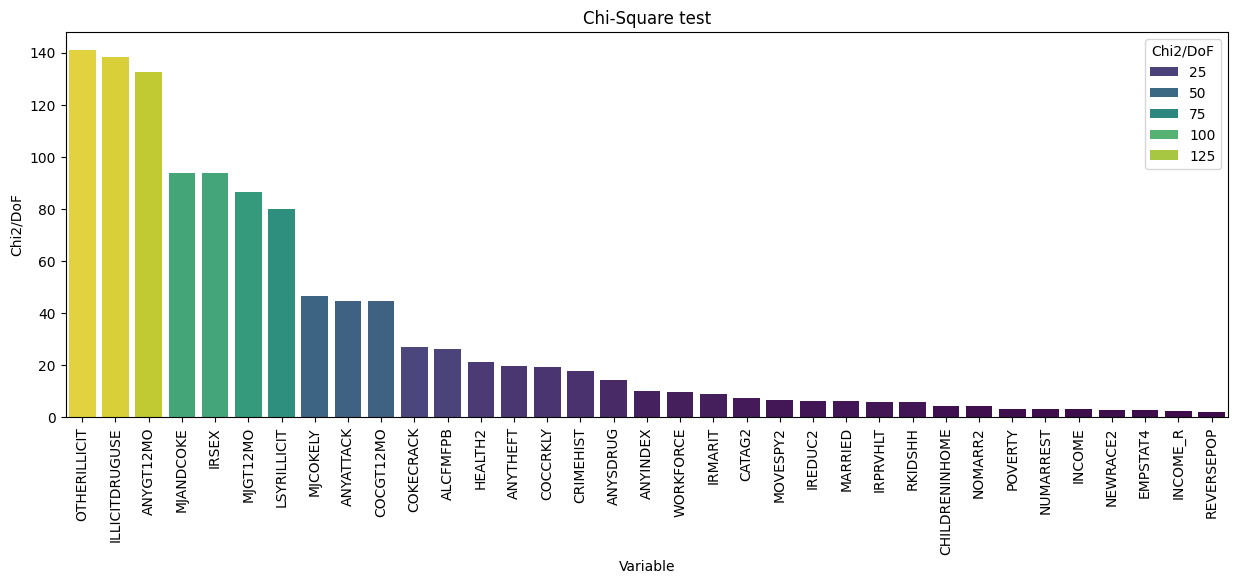

In [290]:
chi2_df = chi2_df[chi2_df['Variable'] != 'SOMATICDEP']

chi2_df = chi2_df[chi2_df["P"] < 0.05]
chi2_df = chi2_df.sort_values(by="Chi2/DoF", ascending=False).reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.title("Chi-Square test")
plt.xticks(rotation=90)
sns.barplot(y="Chi2/DoF", x="Variable", data=chi2_df, palette="viridis", hue="Chi2/DoF")

### Choose N most significant features

In [291]:
N = 10
potential_features = chi2_df["Variable"][:N].to_list()
potential_features

['OTHERILLICIT',
 'ILLICITDRUGUSE',
 'ANYGT12MO',
 'MJANDCOKE',
 'IRSEX',
 'MJGT12MO',
 'LSYRILLICIT',
 'MJCOKELY',
 'ANYATTACK',
 'COCGT12MO']

In [292]:
features = [
    "OTHERILLICIT",
    "ILLICITDRUGUSE",
    "ANYGT12MO",
    "MJANDCOKE",
    "MJGT12MO",
    "LSYRILLICIT",
]
features_df = depression_df[[indicator_col] + features].copy()

### Analysis Performed For Different Groups

In [293]:
groups = ["IRSEX", "SOMATICDEP", age_col]
groups_analysis_df = depression_df[features + groups + [indicator_col]]

In [294]:
def get_chi2_col(df, col, ignore):
    df = df.dropna(subset=[col])
    split_dfs = {category: df[df[col] == category] for category in df[col].unique()}
    analysis = []
    for category, split_df in split_dfs.items():
        chi2_df = get_chi2(
            split_df.drop(columns=ignore),
            indicator_col,
        )
        chi2_df[col] = category
        analysis.append(chi2_df)
    return pd.concat(analysis)


def plot_chi2_dof_col(data, col):
    plt.figure(figsize=(10, 5))
    plt.title(f"Comparison of Chi2/DoF for {col}") 
    sns.barplot(
        y="Chi2/DoF",
        x="Variable",
        data=data,
        hue=col,
    )


def get_col_analysis(df, col, groups):
    chi2_col_df = get_chi2_col(df, col, groups)
    plot_chi2_dof_col(chi2_col_df, col)
    p_value = chi2_col_df[["Variable", col, "P"]]
    p_value = p_value[p_value["P"] > 0.05]
    p_value = p_value.sort_values(by="P", ascending=False).reset_index(drop=True)
    if p_value.empty:
        return None
    return p_value

### Gender
As illustrated by the bar plot, drugs play a much bigger role in the development of depression in women than in men.

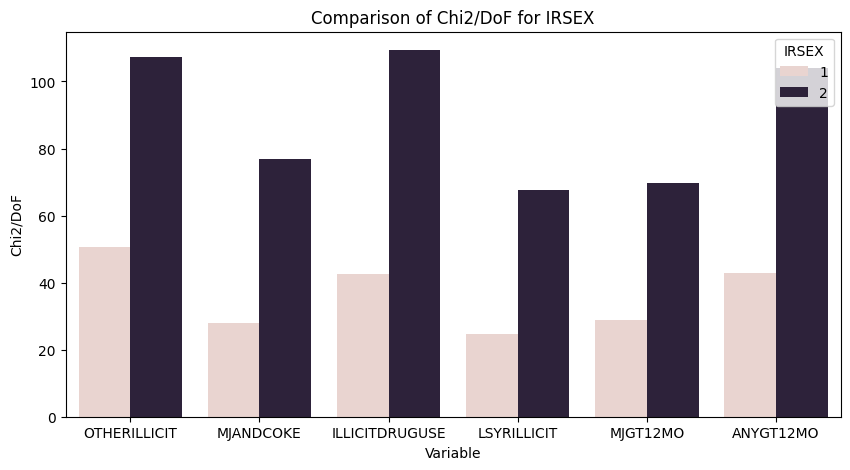

In [295]:
get_col_analysis(groups_analysis_df, "IRSEX", groups)

### Age
As illustrated by the bar plot, younger people are more likely to have drugs induced depression.

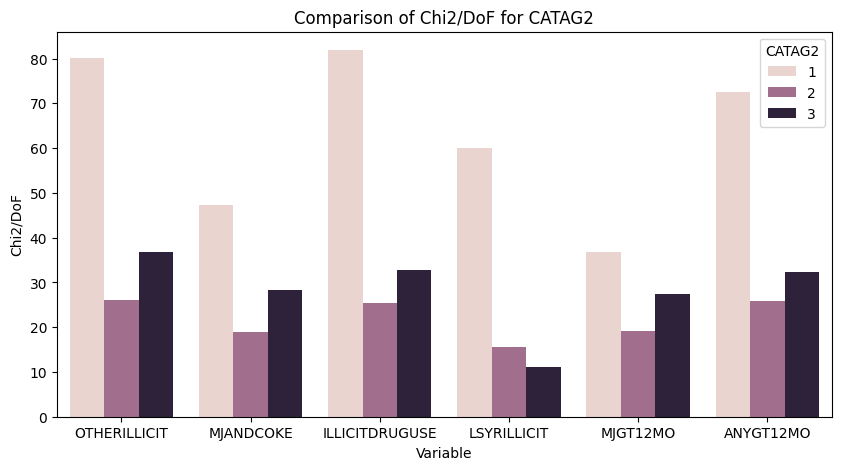

In [296]:
get_col_analysis(groups_analysis_df, age_col, groups)

### Depression Type
As illustrated by the bar plot, different types of depression affect the relative importance of the selected features. One possible explanation is that certain drugs induce symptoms commonly associated with somatic depression.

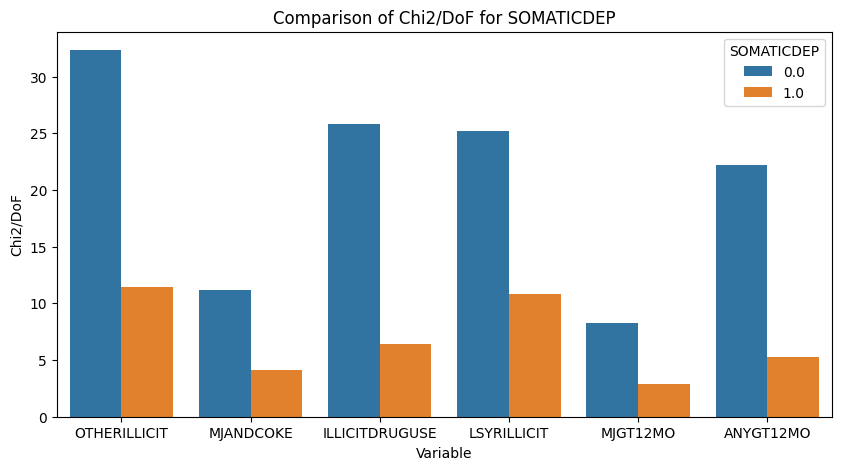

In [297]:
get_col_analysis(groups_analysis_df, "SOMATICDEP", groups)

### Save features for Phase 2

In [298]:
prediction_df = depression_df[[indicator_col] + potential_features].copy()

prediction_df.dropna(inplace=True)
prediction_df.reset_index(drop=True, inplace=True)
prediction_df = prediction_df.astype(int)
prediction_df.to_csv("prediction.csv", index=False)